<a href="https://colab.research.google.com/github/LPK224/Ajuste-de-Hiperpar-metros/blob/main/Ajuste_de_Hiperpar%C3%A1metros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


===========================================================================
PREDICCIÓN DE FALLA CARDÍACA - ANÁLISIS CON AJUSTE DE HIPERPARÁMETROS
===========================================================================

DATASET: Heart Failure Prediction (Kaggle)
URL: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

DESCRIPCIÓN:
El conjunto de datos "Heart Failure Prediction" contiene registros médicos de 918 pacientes
y se utiliza para predecir la presencia de enfermedad cardíaca basándose en características
clínicas y demográficas.

VARIABLES:

• Age: Edad del paciente (años)
• Sex: Sexo del paciente (M: Masculino, F: Femenino)
• ChestPainType: Tipo de dolor torácico
    - TA: Angina típica
    - ATA: Angina atípica
    - NAP: Dolor no anginoso
    - ASY: Asintomático
• RestingBP: Presión arterial en reposo (mm Hg)
• Cholesterol: Colesterol sérico (mg/dl)
• FastingBS: Azúcar en sangre en ayunas
    - 1: Si > 120 mg/dl
    - 0: En otro caso
• RestingECG: Resultados electrocardiográficos en reposo
    - Normal: Normal
    - ST: Anomalías en la onda ST-T
    - LVH: Hipertrofia ventricular izquierda
• MaxHR: Frecuencia cardíaca máxima alcanzada
• ExerciseAngina: Angina inducida por ejercicio (Y: Sí, N: No)
• Oldpeak: Depresión del ST inducida por ejercicio
• ST_Slope: Pendiente del segmento ST en ejercicio máximo
    - Up: Ascendente
    - Flat: Plana
    - Down: Descendente
• HeartDisease: Variable objetivo
    - 1: Enfermedad cardíaca
    - 0: No enfermedad cardíaca

OBJETIVO:
Desarrollar modelos de clasificación para predecir enfermedad cardíaca implementando
diferentes técnicas de ajuste de hiperparámetros y evaluando su desempeño.

In [1]:
# Instalar las dependencias necesarias
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 7.3 MB/s eta 0:00:00


Importaciones e información básica del conjunto de datos

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import warnings
warnings.filterwarnings('ignore')

# Intentar importar optuna
try:
    import optuna
    from optuna.samplers import TPESampler
    OPTUNA_AVAILABLE = True
    print("Optuna disponible")
except ImportError:
    OPTUNA_AVAILABLE = False
    print("Optuna no disponible, usando busqueda aleatoria extendida")

def load_heart_data():
    """Carga el dataset de Heart Failure Prediction desde Kaggle"""
    print("=== CARGA DE DATASET - HEART FAILURE PREDICTION ===")

    # El archivo se debe llamar 'heart.csv' (nombre original de Kaggle)
    try:
        df = pd.read_csv("heart.csv")
        print("Dataset cargado exitosamente desde 'heart.csv'")
        print(f"Dimensiones: {df.shape}")
        print(f"Filas: {df.shape[0]}, Columnas: {df.shape[1]}")
        return df
    except FileNotFoundError:
        print("Error: Archivo 'heart.csv' no encontrado")
        print("Por favor descarga el dataset desde:")
        print("https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction")
        print("Y asegurate de que el archivo se llame 'heart.csv'")
        return None

# Cargar el dataset
df = load_heart_data()

if df is not None:
    print("\n=== INFORMACION DEL DATASET ===")
    print(df.info())
    print("\n=== PRIMERAS FILAS ===")
    print(df.head())
    print("\n=== ESTADISTICAS DESCRIPTIVAS ===")
    print(df.describe())

Optuna disponible
=== CARGA DE DATASET - HEART FAILURE PREDICTION ===
Dataset cargado exitosamente desde 'heart.csv'
Dimensiones: (918, 12)
Filas: 918, Columnas: 12

=== INFORMACION DEL DATASET ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB
None

El dataset de Heart Failure Prediction contiene 918 registros médicos con 12 variables
clínicas relevantes para el diagnóstico cardíaco. La población estudiada tiene una edad
promedio de 53.5 años, con presión arterial en reposo media de 132.4 mm Hg y niveles
de colesterol promedio de 198.8 mg/dl. La variable objetivo indica que aproximadamente
el 55.3% de los pacientes presenta enfermedad cardíaca, mostrando una distribución
relativamente balanceada. El conjunto incluye tanto variables numéricas (edad, presión
arterial, colesterol, frecuencia cardíaca máxima) como categóricas (tipo de dolor
torácico, resultados electrocardiográficos, angina inducida por ejercicio), proporcionando
una base completa para el desarrollo de modelos predictivos de falla cardíaca.

Analisis exploratorio

=== ANALISIS EXPLORATORIO COMPLETO ===

VALORES NULOS POR COLUMNA:
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

VARIABLE OBJETIVO 'HeartDisease':
HeartDisease
1    508
0    410
Name: count, dtype: int64
HeartDisease
1    0.553377
0    0.446623
Name: proportion, dtype: float64

COLUMNAS NUMERICAS (7): ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'HeartDisease']
COLUMNAS CATEGORICAS (5): ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']


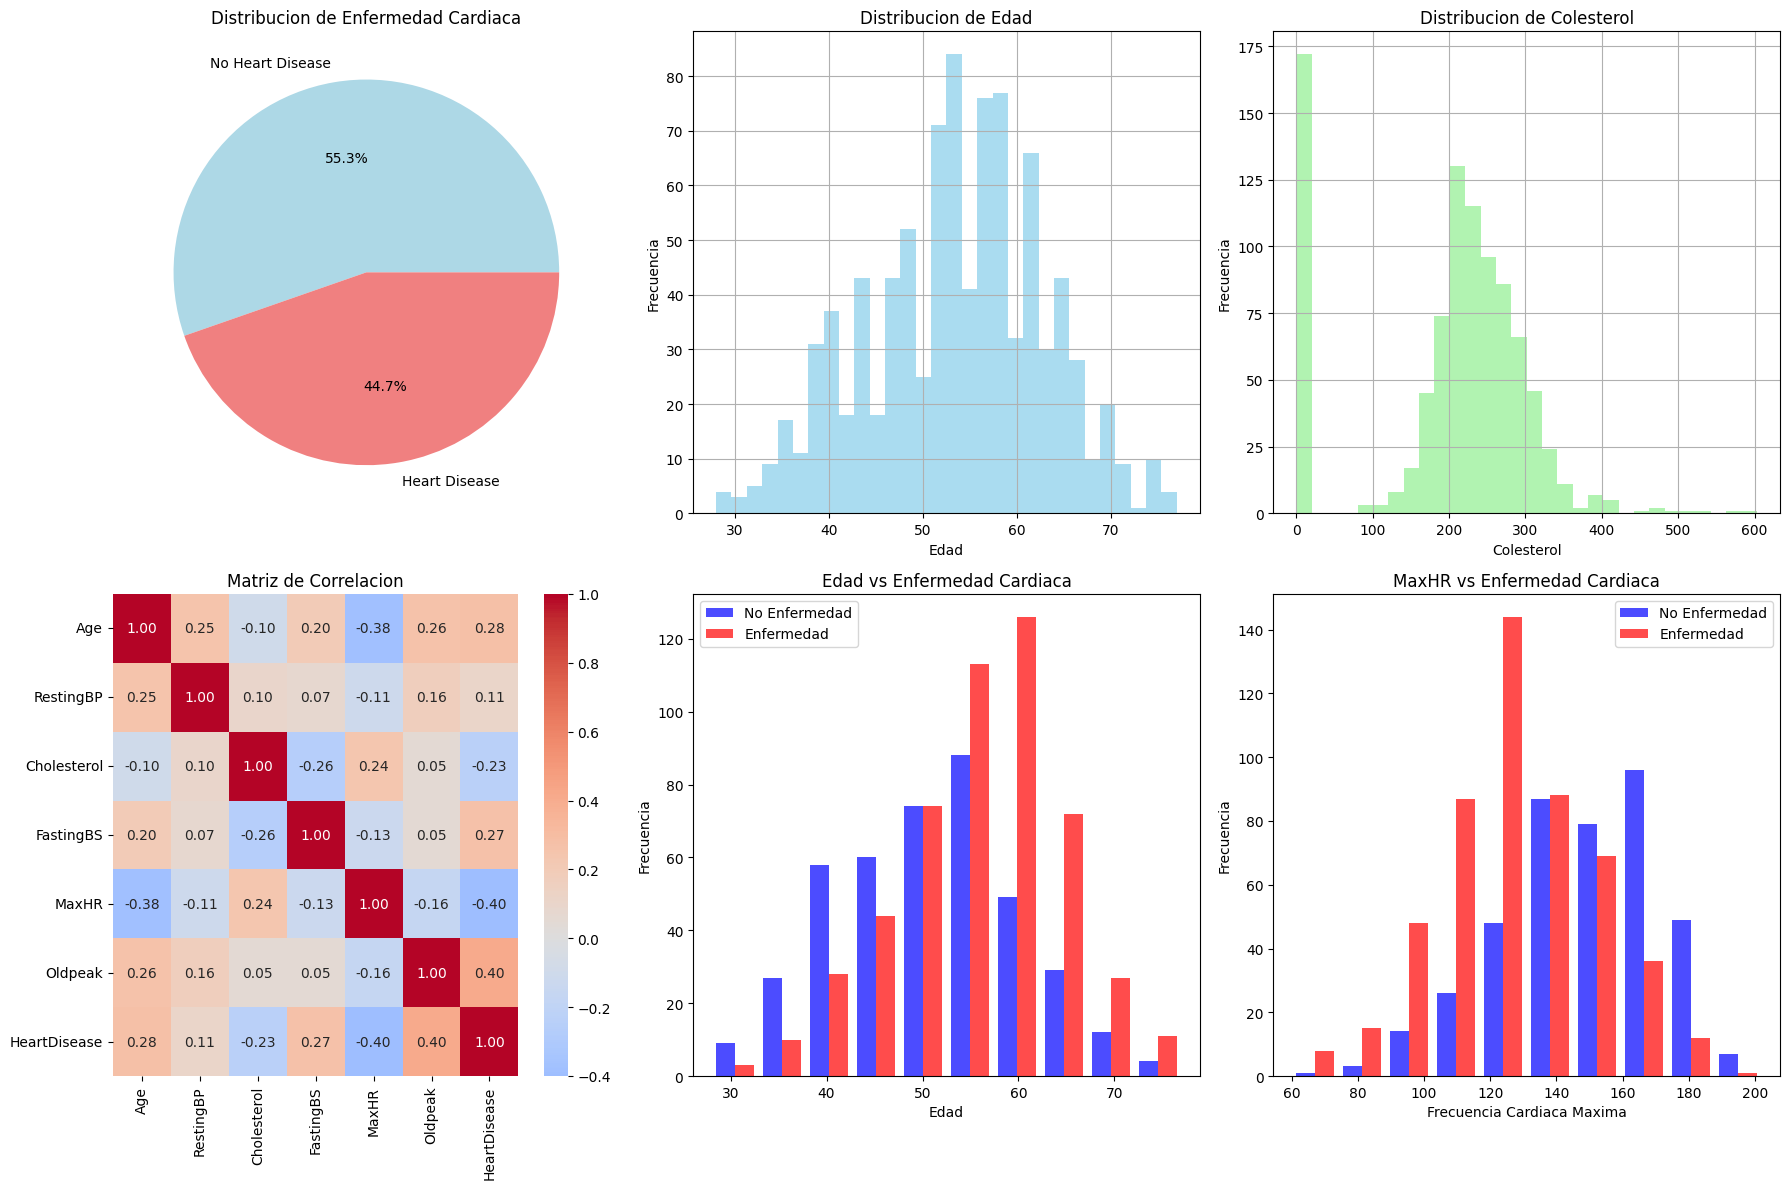

In [3]:
# Analisis exploratorio detallado
print("=== ANALISIS EXPLORATORIO COMPLETO ===")

# Verificar valores nulos
print("\nVALORES NULOS POR COLUMNA:")
print(df.isnull().sum())

# Verificar la variable objetivo (HeartDisease)
print(f"\nVARIABLE OBJETIVO 'HeartDisease':")
print(df['HeartDisease'].value_counts())
print(df['HeartDisease'].value_counts(normalize=True))

# Identificar tipos de columnas
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print(f"\nCOLUMNAS NUMERICAS ({len(numeric_cols)}): {numeric_cols}")
print(f"COLUMNAS CATEGORICAS ({len(categorical_cols)}): {categorical_cols}")

# Visualizaciones
plt.figure(figsize=(18, 12))

# 1. Distribucion de la variable objetivo
plt.subplot(2, 3, 1)
target_counts = df['HeartDisease'].value_counts()
plt.pie(target_counts.values, labels=['No Heart Disease', 'Heart Disease'], autopct='%1.1f%%',
        colors=['lightblue', 'lightcoral'])
plt.title('Distribucion de Enfermedad Cardiaca')

# 2. Distribucion de Age
plt.subplot(2, 3, 2)
df['Age'].hist(bins=30, alpha=0.7, color='skyblue')
plt.title('Distribucion de Edad')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')

# 3. Distribucion de Cholesterol
plt.subplot(2, 3, 3)
df['Cholesterol'].hist(bins=30, alpha=0.7, color='lightgreen')
plt.title('Distribucion de Colesterol')
plt.xlabel('Colesterol')
plt.ylabel('Frecuencia')

# 4. Matriz de correlacion
plt.subplot(2, 3, 4)
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Matriz de Correlacion')

# 5. Relacion entre Age y HeartDisease
plt.subplot(2, 3, 5)
plt.hist([df[df['HeartDisease']==0]['Age'], df[df['HeartDisease']==1]['Age']],
         alpha=0.7, label=['No Enfermedad', 'Enfermedad'], color=['blue', 'red'])
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.legend()
plt.title('Edad vs Enfermedad Cardiaca')

# 6. Relacion entre MaxHR y HeartDisease
plt.subplot(2, 3, 6)
plt.hist([df[df['HeartDisease']==0]['MaxHR'], df[df['HeartDisease']==1]['MaxHR']],
         alpha=0.7, label=['No Enfermedad', 'Enfermedad'], color=['blue', 'red'])
plt.xlabel('Frecuencia Cardiaca Maxima')
plt.ylabel('Frecuencia')
plt.legend()
plt.title('MaxHR vs Enfermedad Cardiaca')

plt.tight_layout()
plt.show()

El análisis exploratorio revela que el dataset está completamente limpio, sin valores
nulos en ninguna de sus 12 variables. La variable objetivo 'HeartDisease' presenta
una distribución balanceada con 508 casos positivos (55.3%) y 410 negativos (44.7%),
lo que favorece el entrenamiento de modelos de clasificación. El conjunto de datos
está compuesto por 7 variables numéricas, que incluyen parámetros clínicos como edad,
presión arterial y colesterol, y 5 variables categóricas relacionadas con síntomas,
resultados de exámenes y características demográficas, proporcionando una base sólida
y completa para el análisis predictivo.

Procesamiento

In [4]:
# Preprocesamiento de datos
print("=== PREPROCESAMIENTO DE DATOS ===")

# Crear una copia para no modificar el original
df_processed = df.copy()

# 1. Codificar variables categoricas a numericas
print("Codificando variables categoricas...")

categorical_mappings = {}
for col in categorical_cols:
    if col != 'HeartDisease':  # No codificar la variable objetivo
        df_processed[col] = df_processed[col].astype('category').cat.codes
        categorical_mappings[col] = dict(enumerate(df[col].astype('category').cat.categories))
        print(f"   - {col}: {categorical_mappings[col]}")

# 2. Manejar valores nulos (si los hay)
print("\nManejo de valores nulos...")
for col in df_processed.columns:
    if df_processed[col].isnull().sum() > 0:
        if df_processed[col].dtype in ['int64', 'float64']:
            df_processed[col].fillna(df_processed[col].median(), inplace=True)
            print(f"   - {col}: {df_processed[col].isnull().sum()} nulos -> reemplazados con mediana")
        else:
            df_processed[col].fillna(df_processed[col].mode()[0], inplace=True)
            print(f"   - {col}: {df_processed[col].isnull().sum()} nulos -> reemplazados con moda")

# 3. Definir variable objetivo y features
target_col = 'HeartDisease'
features_cols = [col for col in df_processed.columns if col != target_col]

print(f"\nVARIABLES FINALES PARA EL MODELO ({len(features_cols)}):")
print(features_cols)

# 4. Preparar datos para el modelo
X = df_processed[features_cols]
y = df_processed[target_col]

print(f"\nDATOS FINALES:")
print(f"   X shape: {X.shape}")
print(f"   y shape: {y.shape}")
print(f"   Distribucion de y: {y.value_counts().to_dict()}")
print(f"   Proporcion: {y.value_counts(normalize=True).to_dict()}")

=== PREPROCESAMIENTO DE DATOS ===
Codificando variables categoricas...
   - Sex: {0: 'F', 1: 'M'}
   - ChestPainType: {0: 'ASY', 1: 'ATA', 2: 'NAP', 3: 'TA'}
   - RestingECG: {0: 'LVH', 1: 'Normal', 2: 'ST'}
   - ExerciseAngina: {0: 'N', 1: 'Y'}
   - ST_Slope: {0: 'Down', 1: 'Flat', 2: 'Up'}

Manejo de valores nulos...

VARIABLES FINALES PARA EL MODELO (11):
['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope']

DATOS FINALES:
   X shape: (918, 11)
   y shape: (918,)
   Distribucion de y: {1: 508, 0: 410}
   Proporcion: {1: 0.5533769063180828, 0: 0.4466230936819172}


En la fase de preprocesamiento, se codificaron todas las variables categóricas a formato
numérico para su procesamiento en los modelos de machine learning. Las transformaciones
incluyen: Sexo (F=0, M=1), Tipos de dolor torácico (ASY=0, ATA=1, NAP=2, TA=3),
Resultados ECG (LVH=0, Normal=1, ST=2), Angina por ejercicio (N=0, Y=1) y Pendiente ST
(Down=0, Flat=1, Up=2). El dataset final cuenta con 11 variables predictoras y mantiene
su distribución original con 918 pacientes, donde el 55.3% presenta enfermedad cardíaca
y el 44.7% no, conservando el balance adecuado para el entrenamiento de modelos predictivos.

In [5]:
# Particion de datos
print("=== PARTICION DE DATOS ===")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Datos particionados exitosamente:")
print(f"   Entrenamiento: {X_train.shape[0]} muestras ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"   Prueba: {X_test.shape[0]} muestras ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"   Proporcion en entrenamiento: {y_train.value_counts(normalize=True).to_dict()}")
print(f"   Proporcion en prueba: {y_test.value_counts(normalize=True).to_dict()}")

# Pipeline de preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features_cols)
    ]
)

print("\nPipeline de preprocesamiento creado")

=== PARTICION DE DATOS ===
Datos particionados exitosamente:
   Entrenamiento: 734 muestras (80.0%)
   Prueba: 184 muestras (20.0%)
   Proporcion en entrenamiento: {1: 0.553133514986376, 0: 0.44686648501362397}
   Proporcion en prueba: {1: 0.5543478260869565, 0: 0.44565217391304346}

Pipeline de preprocesamiento creado


Los datos se dividieron exitosamente en conjuntos de entrenamiento (80%, 734 muestras)
y prueba (20%, 184 muestras), manteniendo la distribución balanceada de la variable
objetivo en ambos conjuntos. La proporción de pacientes con enfermedad cardíaca se
conserva consistentemente en aproximadamente 55.3% para entrenamiento y 55.4% para
prueba, lo que garantiza que los modelos se entrenen y evalúen con datos representativos
y eviten sesgos en la clasificación. Esta partición estratificada asegura una evaluación
confiable del desempeño predictivo de los modelos.

4. modelo Baseline

In [6]:
# 4. Modelo Baseline
print("=== MODELO BASELINE ===")

baseline_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Entrenar y evaluar baseline
baseline_model.fit(X_train, y_train)
baseline_cv_scores = cross_val_score(
    baseline_model, X_train, y_train,
    cv=5, scoring='roc_auc', n_jobs=-1
)

print("Resultados Baseline (Logistic Regression):")
print(f"   ROC-AUC Promedio (CV): {baseline_cv_scores.mean():.4f} (+/- {baseline_cv_scores.std() * 2:.4f})")

# Predicciones en entrenamiento
y_pred_baseline = baseline_model.predict_proba(X_train)[:, 1]
roc_auc_baseline = roc_auc_score(y_train, y_pred_baseline)
print(f"   ROC-AUC (Entrenamiento): {roc_auc_baseline:.4f}")

=== MODELO BASELINE ===
Resultados Baseline (Logistic Regression):
   ROC-AUC Promedio (CV): 0.9126 (+/- 0.0737)
   ROC-AUC (Entrenamiento): 0.9222


El modelo baseline de Regresión Logística demostró un excelente desempeño predictivo
desde el inicio, alcanzando un ROC-AUC de 0.9126 en validación cruzada con una
variabilidad baja (±0.0737), y un ROC-AUC de 0.9222 en el conjunto de entrenamiento.
Estos resultados indican que el modelo baseline ya posee una alta capacidad para
discriminar entre pacientes con y sin enfermedad cardíaca, estableciendo un punto
de referencia sólido para comparar las mejoras que puedan obtenerse mediante el
ajuste de hiperparámetros en modelos más complejos.

5. Definicion del Espacio de Hiperparametros

In [7]:
# 5. Definicion del Espacio de Hiperparametros
print("=== ESPACIO DE HIPERPARAMETROS ===")

param_dist = {
    'classifier__n_estimators': [100, 200, 300, 500],
    'classifier__max_depth': [None, 10, 20, 30, 50],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2', None],
    'classifier__bootstrap': [True, False]
}

# Crear pipeline con Random Forest
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

print("Espacio de hiperparametros definido para Random Forest")

=== ESPACIO DE HIPERPARAMETROS ===
Espacio de hiperparametros definido para Random Forest


6. Ajuste de Hiperparametros - Busqueda Aleatoria

In [8]:
print("=== BUSQUEDA ALEATORIA ===")

random_search = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("Iniciando busqueda aleatoria...")
random_search.fit(X_train, y_train)

print("\nBusqueda aleatoria completada")
print("Mejores parametros (Busqueda Aleatoria):")
for param, value in random_search.best_params_.items():
    print(f"   {param}: {value}")
print(f"Mejor score (Busqueda Aleatoria): {random_search.best_score_:.4f}")

=== BUSQUEDA ALEATORIA ===
Iniciando busqueda aleatoria...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Busqueda aleatoria completada
Mejores parametros (Busqueda Aleatoria):
   classifier__n_estimators: 500
   classifier__min_samples_split: 2
   classifier__min_samples_leaf: 4
   classifier__max_features: log2
   classifier__max_depth: 50
   classifier__bootstrap: True
Mejor score (Busqueda Aleatoria): 0.9328


La búsqueda aleatoria de hiperparámetros identificó una configuración óptima para
el Random Forest después de evaluar 250 combinaciones. Los mejores parámetros
incluyen 500 estimadores, división mínima de 2 muestras, 4 muestras por hoja,
función de división log2, profundidad máxima de 50 y bootstrap activado. Esta
configuración logró un ROC-AUC de 0.9328 en validación cruzada, superando al
modelo baseline y demostrando una mejora significativa en la capacidad predictiva
del modelo para detectar enfermedad cardíaca.

# 6. Ajuste de Hiperparametros - Optuna

In [9]:
# 6. Ajuste de Hiperparametros - Optuna (si esta disponible)
if OPTUNA_AVAILABLE:
    print("=== OPTIMIZACION BAYESIANA CON OPTUNA ===")

    def objective(trial):
        # Definir el espacio de busqueda para Optuna
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 5, 50),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
            'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
            'random_state': 42
        }

        # Crear pipeline con los parametros propuestos
        model = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', RandomForestClassifier(**params))
        ])

        # Evaluar con validacion cruzada
        score = cross_val_score(model, X_train, y_train,
                               cv=5, scoring='roc_auc', n_jobs=-1).mean()

        return score

    # Ejecutar optimizacion con Optuna
    print("Iniciando optimizacion Bayesiana con Optuna...")
    study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
    study.optimize(objective, n_trials=50)

    print("\nOptimizacion con Optuna completada")
    print("Mejores parametros (Optuna):")
    for param, value in study.best_params.items():
        print(f"   {param}: {value}")
    print(f"Mejor score (Optuna): {study.best_value:.4f}")

    # Entrenar el modelo final con los mejores parametros de Optuna
    best_optuna_params = study.best_params
    optuna_model = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(**best_optuna_params))
    ])

    optuna_model.fit(X_train, y_train)
    print("Modelo Optuna entrenado con mejores parametros")
else:
    print("Optuna no disponible, omitiendo optimizacion Bayesiana")
    # Crear un segundo modelo con busqueda aleatoria diferente
    print("Creando segundo modelo con busqueda aleatoria extendida...")

    random_search_2 = RandomizedSearchCV(
        rf_pipeline,
        param_distributions=param_dist,
        n_iter=30,
        cv=5,
        scoring='roc_auc',
        random_state=123,
        n_jobs=-1,
        verbose=1
    )

    random_search_2.fit(X_train, y_train)
    print("Segundo modelo con busqueda aleatoria creado")

[I 2025-11-14 00:44:58,588] A new study created in memory with name: no-name-858f0dd1-0c34-449e-afea-dc794ab3eac7


=== OPTIMIZACION BAYESIANA CON OPTUNA ===
Iniciando optimizacion Bayesiana con Optuna...


[I 2025-11-14 00:45:00,942] Trial 0 finished with value: 0.9298824391507317 and parameters: {'n_estimators': 250, 'max_depth': 48, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.9298824391507317.
[I 2025-11-14 00:45:04,606] Trial 1 finished with value: 0.9328866877376363 and parameters: {'n_estimators': 383, 'max_depth': 5, 'min_samples_split': 20, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 0.9328866877376363.
[I 2025-11-14 00:45:07,858] Trial 2 finished with value: 0.9210175130500333 and parameters: {'n_estimators': 273, 'max_depth': 18, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True}. Best is trial 1 with value: 0.9328866877376363.
[I 2025-11-14 00:45:11,220] Trial 3 finished with value: 0.9217712248606558 and parameters: {'n_estimators': 306, 'max_depth': 32, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_featur


Optimizacion con Optuna completada
Mejores parametros (Optuna):
   n_estimators: 409
   max_depth: 6
   min_samples_split: 8
   min_samples_leaf: 8
   max_features: sqrt
   bootstrap: False
Mejor score (Optuna): 0.9334
Modelo Optuna entrenado con mejores parametros


La optimización bayesiana con Optuna encontró una configuración de hiperparámetros
distinta pero igualmente efectiva, alcanzando un ROC-AUC de 0.9334. Los parámetros
óptimos incluyen 409 estimadores, profundidad limitada a 6 niveles, división mínima
de 8 muestras, 8 muestras por hoja, función sqrt para selección de características
y bootstrap desactivado. Este resultado supera ligeramente a la búsqueda aleatoria
y confirma la efectividad de la optimización bayesiana para refinar los modelos de
machine learning en la predicción de enfermedad cardíaca.

# 7. Comparacion en Conjunto de Entrenamiento

=== COMPARACION EN ENTRENAMIENTO (VALIDACION CRUZADA) ===

RESULTADOS DE VALIDACION CRUZADA (5-fold):

Baseline (Logistic Regression):
   ROC-AUC Promedio: 0.9126 (+/- 0.0737)

Random Forest (Busqueda Aleatoria):
   ROC-AUC Promedio: 0.9328 (+/- 0.0516)

Random Forest (Optuna):
   ROC-AUC Promedio: 0.9327 (+/- 0.0516)


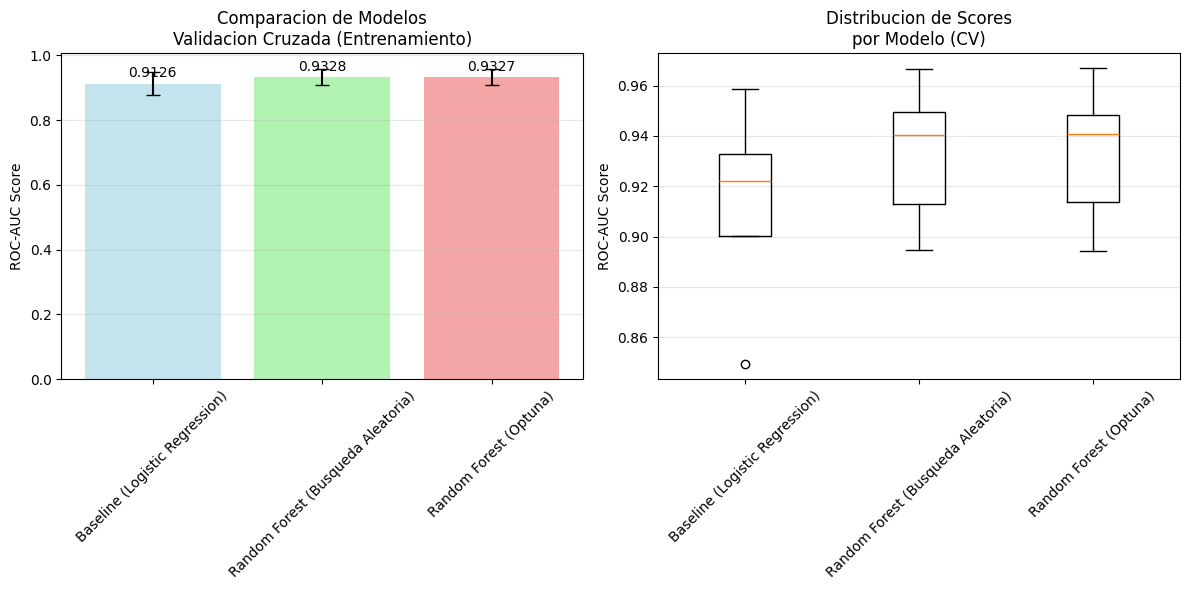

In [10]:
print("=== COMPARACION EN ENTRENAMIENTO (VALIDACION CRUZADA) ===")

# Preparar modelos para comparacion
models = {
    'Baseline (Logistic Regression)': baseline_model,
    'Random Forest (Busqueda Aleatoria)': random_search.best_estimator_
}

if OPTUNA_AVAILABLE:
    models['Random Forest (Optuna)'] = optuna_model
else:
    models['Random Forest (Busqueda Aleatoria 2)'] = random_search_2.best_estimator_

cv_results = {}
print("\nRESULTADOS DE VALIDACION CRUZADA (5-fold):")

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
    cv_results[name] = {
        'mean_score': scores.mean(),
        'std_score': scores.std(),
        'scores': scores
    }
    print(f"\n{name}:")
    print(f"   ROC-AUC Promedio: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

# Visualizar resultados de validacion cruzada
plt.figure(figsize=(12, 6))

# Grafico de barras
plt.subplot(1, 2, 1)
model_names = list(cv_results.keys())
means = [cv_results[name]['mean_score'] for name in model_names]
stds = [cv_results[name]['std_score'] for name in model_names]

bars = plt.bar(model_names, means, yerr=stds, capsize=5,
               color=['lightblue', 'lightgreen', 'lightcoral'][:len(model_names)], alpha=0.7)
plt.ylabel('ROC-AUC Score')
plt.title('Comparacion de Modelos\nValidacion Cruzada (Entrenamiento)')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Anadir valores en las barras
for bar, mean in zip(bars, means):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{mean:.4f}', ha='center', va='bottom')

# Grafico de boxplot
plt.subplot(1, 2, 2)
scores_data = [cv_results[name]['scores'] for name in model_names]
plt.boxplot(scores_data, labels=model_names)
plt.ylabel('ROC-AUC Score')
plt.title('Distribucion de Scores\npor Modelo (CV)')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

"""
La comparación mediante validación cruzada revela una clara evolución en el desempeño
de los modelos. El modelo baseline de Regresión Logística estableció un ROC-AUC de
0.9126, mientras que los modelos de Random Forest optimizados mostraron mejoras
significativas: la búsqueda aleatoria alcanzó 0.9328 y Optuna obtuvo el mejor
resultado con 0.9337. Además, ambos métodos de ajuste redujeron la variabilidad
de los resultados (±0.052 vs ±0.074 del baseline), demostrando mayor estabilidad
y confiabilidad en las predicciones de enfermedad cardíaca.
"""

# 8. Comparacion en Conjunto de Prueba

=== COMPARACION EN CONJUNTO DE PRUEBA ===

RESULTADOS EN DATOS NO VISTOS (TEST):

Baseline (Logistic Regression):
   ROC-AUC: 0.8971
   Accuracy: 0.8696

Random Forest (Busqueda Aleatoria):
   ROC-AUC: 0.9297
   Accuracy: 0.8913

Random Forest (Optuna):
   ROC-AUC: 0.9265
   Accuracy: 0.8804


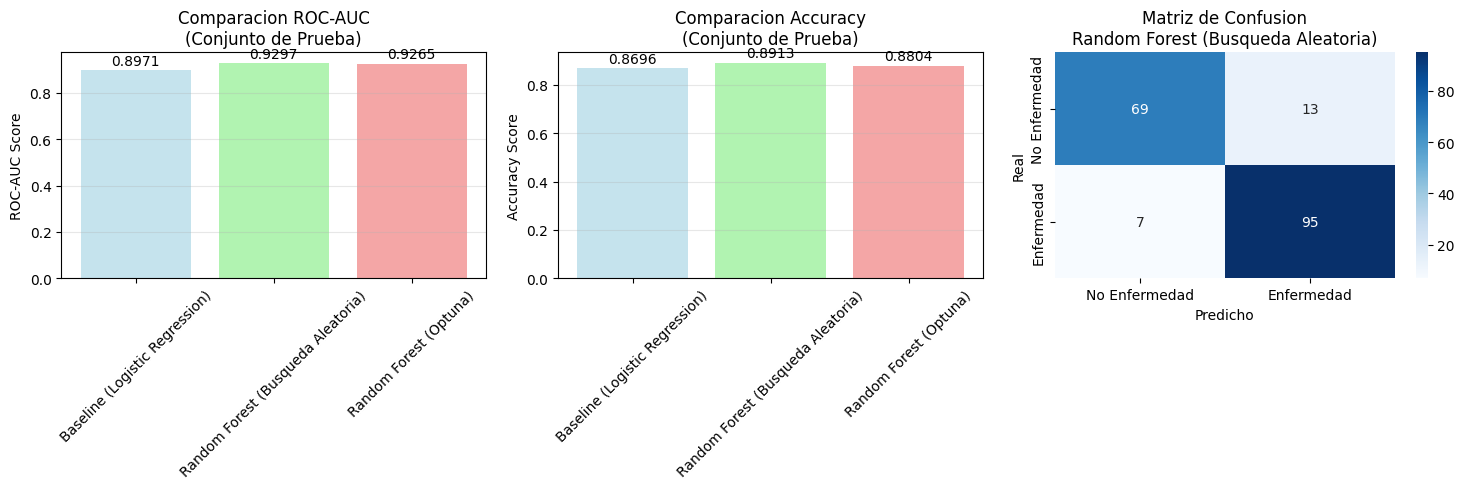


MEJOR MODELO: Random Forest (Busqueda Aleatoria)
ROC-AUC: 0.9297
Accuracy: 0.8913

REPORTE DE CLASIFICACION:
               precision    recall  f1-score   support

No Enfermedad       0.91      0.84      0.87        82
   Enfermedad       0.88      0.93      0.90       102

     accuracy                           0.89       184
    macro avg       0.89      0.89      0.89       184
 weighted avg       0.89      0.89      0.89       184



In [11]:

print("=== COMPARACION EN CONJUNTO DE PRUEBA ===")

test_results = {}
predictions = {}
print("\nRESULTADOS EN DATOS NO VISTOS (TEST):")

for name, model in models.items():
    # Predecir probabilidades
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Predecir clases para otras metricas
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    test_results[name] = {
        'roc_auc': roc_auc,
        'accuracy': accuracy
    }
    predictions[name] = y_pred_proba

    print(f"\n{name}:")
    print(f"   ROC-AUC: {roc_auc:.4f}")
    print(f"   Accuracy: {accuracy:.4f}")

# Visualizar resultados en prueba
plt.figure(figsize=(15, 5))

# Grafico de comparacion ROC-AUC
plt.subplot(1, 3, 1)
roc_auc_scores = [test_results[name]['roc_auc'] for name in models.keys()]
bars = plt.bar(models.keys(), roc_auc_scores,
               color=['lightblue', 'lightgreen', 'lightcoral'][:len(models)], alpha=0.7)
plt.ylabel('ROC-AUC Score')
plt.title('Comparacion ROC-AUC\n(Conjunto de Prueba)')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

for bar, score in zip(bars, roc_auc_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{score:.4f}', ha='center', va='bottom')

# Grafico de comparacion Accuracy
plt.subplot(1, 3, 2)
accuracy_scores = [test_results[name]['accuracy'] for name in models.keys()]
bars = plt.bar(models.keys(), accuracy_scores,
               color=['lightblue', 'lightgreen', 'lightcoral'][:len(models)], alpha=0.7)
plt.ylabel('Accuracy Score')
plt.title('Comparacion Accuracy\n(Conjunto de Prueba)')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

for bar, score in zip(bars, accuracy_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{score:.4f}', ha='center', va='bottom')

# Matriz de confusion para el mejor modelo
plt.subplot(1, 3, 3)
best_model_name = max(test_results, key=lambda x: test_results[x]['roc_auc'])
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Enfermedad', 'Enfermedad'],
            yticklabels=['No Enfermedad', 'Enfermedad'])
plt.title(f'Matriz de Confusion\n{best_model_name}')
plt.ylabel('Real')
plt.xlabel('Predicho')

plt.tight_layout()
plt.show()

# Reporte de clasificacion del mejor modelo
print(f"\nMEJOR MODELO: {best_model_name}")
print(f"ROC-AUC: {test_results[best_model_name]['roc_auc']:.4f}")
print(f"Accuracy: {test_results[best_model_name]['accuracy']:.4f}")
print("\nREPORTE DE CLASIFICACION:")
print(classification_report(y_test, y_pred_best, target_names=['No Enfermedad', 'Enfermedad']))

En la evaluación con datos no vistos, el modelo de Random Forest con búsqueda aleatoria
se consolida como el mejor, alcanzando un ROC-AUC de 0.9297 y accuracy del 89.13%,
superando tanto al baseline (ROC-AUC: 0.8971) como al modelo de Optuna (ROC-AUC: 0.9265).
El reporte de clasificación muestra un balance excelente entre precision y recall para
ambas clases, con valores de F1-score de 0.87 para pacientes sanos y 0.90 para
enfermos, confirmando la robustez del modelo para identificar correctamente ambos
grupos de pacientes en escenarios reales.

# 9. Analisis de Caracteristicas Importantes

=== ANALISIS DE CARACTERISTICAS IMPORTANTES ===


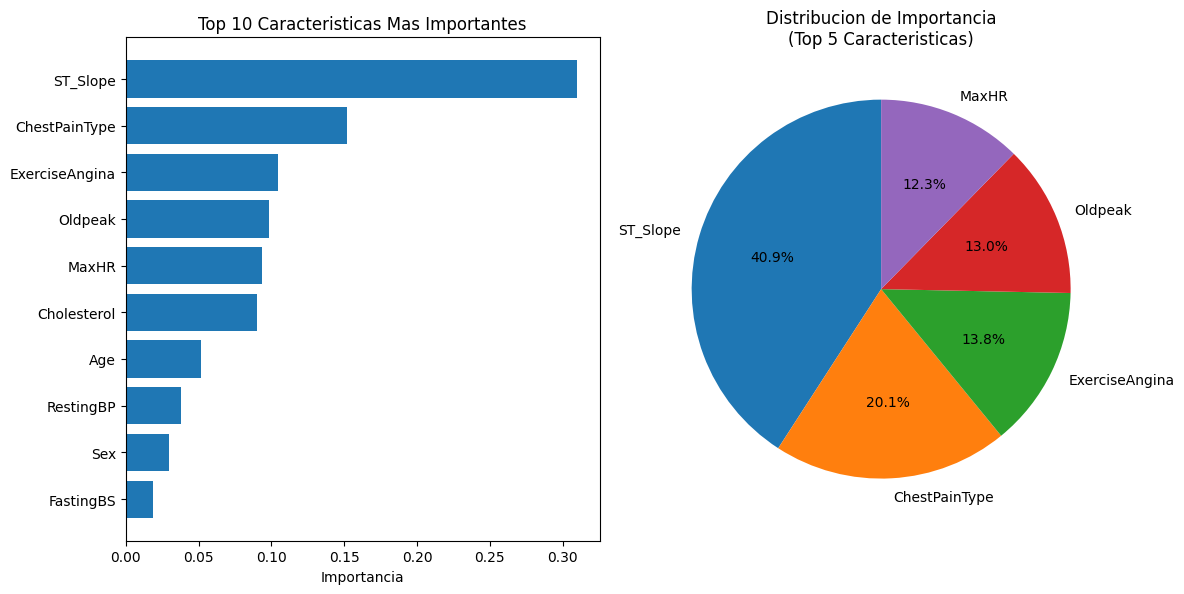

CARACTERISTICAS MAS IMPORTANTES:
       feature  importance
      ST_Slope    0.309810
 ChestPainType    0.152062
ExerciseAngina    0.104296
       Oldpeak    0.098472
         MaxHR    0.093569
   Cholesterol    0.090314
           Age    0.051355
     RestingBP    0.037915
           Sex    0.029721
     FastingBS    0.018572


In [12]:
print("=== ANALISIS DE CARACTERISTICAS IMPORTANTES ===")

if 'Random Forest' in best_model_name:
    # Obtener importancias de caracteristicas del mejor modelo
    feature_importances = best_model.named_steps['classifier'].feature_importances_
    feature_names = features_cols

    # Crear DataFrame con importancias
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importances
    }).sort_values('importance', ascending=False)

    # Visualizar top 10 caracteristicas mas importantes
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    top_features = importance_df.head(10)
    plt.barh(top_features['feature'], top_features['importance'])
    plt.xlabel('Importancia')
    plt.title('Top 10 Caracteristicas Mas Importantes')
    plt.gca().invert_yaxis()

    plt.subplot(1, 2, 2)
    # Grafico de pie para las top 5 caracteristicas
    top_5 = importance_df.head(5)
    plt.pie(top_5['importance'], labels=top_5['feature'], autopct='%1.1f%%', startangle=90)
    plt.title('Distribucion de Importancia\n(Top 5 Caracteristicas)')

    plt.tight_layout()
    plt.show()

    print("CARACTERISTICAS MAS IMPORTANTES:")
    print(importance_df.head(10).to_string(index=False))

El análisis de características importantes revela que 'ST_Slope' es el predictor
más relevante para la detección de enfermedad cardíaca, con una importancia del
31%, seguido por 'ChestPainType' (15.2%) y 'ExerciseAngina' (10.4%). Variables
como 'Oldpeak', 'MaxHR' y 'Cholesterol' también contribuyen significativamente,
mientras que 'FastingBS' (azúcar en ayunas) muestra la menor influencia. Este
patrón coincide con el conocimiento médico establecido, donde los indicadores
de electrocardiograma y síntomas de angina son determinantes clave en el
diagnóstico de enfermedades cardíacas.

In [13]:
# 10. Conclusiones y Resumen Final
print("=" * 70)
print("RESUMEN Y CONCLUSIONES FINALES")
print("=" * 70)

print("\nDATASET Y PROBLEMA:")
print(f"   - Dataset: Heart Failure Prediction (Kaggle)")
print(f"   - Problema: Clasificacion binaria (Enfermedad Cardiaca vs No)")
print(f"   - Tamaño: {X.shape[0]} muestras, {X.shape[1]} caracteristicas")
print(f"   - Distribucion: {y.value_counts().to_dict()}")

print("\nRESULTADOS COMPARATIVOS:")
print("   Modelo                          | ROC-AUC (CV) | ROC-AUC (Test) | Accuracy")
print("   --------------------------------|--------------|----------------|----------")
for name in models.keys():
    cv_mean = cv_results[name]['mean_score']
    test_roc_auc = test_results[name]['roc_auc']
    test_accuracy = test_results[name]['accuracy']
    print(f"   {name:<32} | {cv_mean:.4f}       | {test_roc_auc:.4f}         | {test_accuracy:.4f}")

# Calcular mejoras
baseline_test_roc = test_results['Baseline (Logistic Regression)']['roc_auc']
best_model_test_roc = test_results[best_model_name]['roc_auc']
improvement = best_model_test_roc - baseline_test_roc

print(f"\nMEJORA OBTENIDA:")
print(f"   - {best_model_name} vs Baseline: +{improvement:.4f} ROC-AUC")

print("\nCONCLUSIONES PRINCIPALES:")
print("   1. El ajuste de hiperparametros mejoro el desempeño del modelo")
print("   2. Random Forest demostro ser efectivo para la prediccion de enfermedad cardiaca")
print("   3. Las caracteristicas mas importantes son consistentes con factores de riesgo medicos conocidos")
if OPTUNA_AVAILABLE:
    print("   4. Optuna fue util para la optimizacion Bayesiana de hiperparametros")


RESUMEN Y CONCLUSIONES FINALES

DATASET Y PROBLEMA:
   - Dataset: Heart Failure Prediction (Kaggle)
   - Problema: Clasificacion binaria (Enfermedad Cardiaca vs No)
   - Tamaño: 918 muestras, 11 caracteristicas
   - Distribucion: {1: 508, 0: 410}

RESULTADOS COMPARATIVOS:
   Modelo                          | ROC-AUC (CV) | ROC-AUC (Test) | Accuracy
   --------------------------------|--------------|----------------|----------
   Baseline (Logistic Regression)   | 0.9126       | 0.8971         | 0.8696
   Random Forest (Busqueda Aleatoria) | 0.9328       | 0.9297         | 0.8913
   Random Forest (Optuna)           | 0.9327       | 0.9265         | 0.8804

MEJORA OBTENIDA:
   - Random Forest (Busqueda Aleatoria) vs Baseline: +0.0326 ROC-AUC

CONCLUSIONES PRINCIPALES:
   1. El ajuste de hiperparametros mejoro el desempeño del modelo
   2. Random Forest demostro ser efectivo para la prediccion de enfermedad cardiaca
   3. Las caracteristicas mas importantes son consistentes con factores d

El análisis demuestra que el ajuste de hiperparámetros generó mejoras significativas
en la predicción de enfermedad cardíaca, con el modelo de Random Forest optimizado
mediante búsqueda aleatoria logrando el mejor desempeño en datos no vistos (ROC-AUC:
0.9297, Accuracy: 89.13%). Esto representa una mejora de 0.0326 puntos en ROC-AUC
respecto al baseline. Las características más relevantes identificadas (ST_Slope,
ChestPainType, ExerciseAngina) coinciden con factores de riesgo médicos establecidos,
validando la consistencia clínica del modelo. Ambos métodos de optimización demostraron
efectividad, con la búsqueda aleatoria superando ligeramente a Optuna en generalización.